# Lens Modeling for DESIJ1539+1650

**Authors:** Sulyman Hossain, Zannat Chowdhury, Anowar J. Shajib\
**Acknowledgement(s):**

In [1]:
!pip install lenstronomy
!pip install cobaya
!pip install emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for lenstronomy: filename=lenstronomy-1.11.5-py3-none-any.whl size=1139065 sha256=c277b01479fb41b8d447bb872dfdf85032b5868f69bd9baa1adfa6c92dc5dc16
  Stored in directory: /root/.cache/pip/wheels/78/dd/d9/bbdd80cec79b57ec559b7183476b0e8802a2c029e312d05b0f
  Created wheel for schwimmbad: filename=schwimmbad-0.3.2-py3-none-any.whl size=15729 sha256=5a29a1d8d32c98c8da72e57f284d0016a46daae4879792b94315f395ecc99d7c
  Stored in directory: /root/.cache/pip/wheels/4a/ea/3e/b79646d96eaea548b8eec6d2caed656a3c7f17ce5f264484b8
Successfully built lenstronomy schwimmbad
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440

#### Importing the required packages

In [2]:
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
"""src_path = r"/kaggle/input/zannats-output-filesnew/mcmc_backend.h5"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)"""

'src_path = r"/kaggle/input/zannats-output-filesnew/mcmc_backend.h5"\ndst_path = r"/kaggle/working/"\nshutil.copy(src_path, dst_path)'

#### Read the data file

In [4]:
with h5py.File("/kaggle/input/desij1539-1650-system/DESIJ15391650_F140W.h5", "r") as f:
    kwargs_data = {}

    for key in f:
        if key == "exposure_time":
            kwargs_data[key] = f[key][()]
            continue
        kwargs_data[key] = f[key][()]

# print kwargs_data
for key in kwargs_data:
    print(f"{key}: {kwargs_data[key]}")

background_rms: 0.013182383426603758
dec_at_xy_0: -9.23999999999999
exposure_time: [[490.90875 421.75388 439.10574 ... 486.56738 406.6674  548.1046 ]
 [447.409   503.6679  418.47308 ... 592.03424 454.74384 466.78656]
 [441.13593 567.0645  418.47824 ... 464.80774 433.77225 425.30106]
 ...
 [604.4732  476.06665 545.15735 ... 528.9927  497.26175 367.77853]
 [490.31616 330.20276 396.50378 ... 341.58386 422.0971  425.519  ]
 [451.5098  483.99115 520.6441  ... 475.88297 564.95496 522.05316]]
image_data: [[ 0.00067712 -0.01423318  0.00151635 ... -0.00029543 -0.00692246
  -0.0166516 ]
 [ 0.00363533 -0.00039791 -0.01873723 ...  0.01981123  0.00081102
   0.00612396]
 [-0.01712817 -0.00955698 -0.0194798  ...  0.00040743 -0.00297122
  -0.00672446]
 ...
 [ 0.00515814  0.00832129 -0.00283378 ... -0.00238547  0.00146614
  -0.00219803]
 [-0.00667532  0.00798152  0.00278799 ...  0.00431538  0.00754044
  -0.00536348]
 [-0.00077069  0.0147179   0.00402649 ... -0.00141456 -0.0080586
   0.00624329]]
ra_at_

#### Load PSF data


In [5]:
with h5py.File("/kaggle/input/desij1539-1650-system/psf_F140W.h5", "r") as f:
    kwargs_psf = {}

    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf["psf_type"] = "PIXEL"
print(kwargs_psf)

{'kernel_point_source': array([[5.7422681e-06, 4.5087054e-06, 2.4900439e-06, ..., 1.8486933e-06,
        3.2385867e-06, 4.4331632e-06],
       [3.9503216e-06, 9.9817180e-06, 6.5966469e-06, ..., 3.9997908e-06,
        6.6143798e-06, 4.1430776e-06],
       [2.9697005e-06, 5.5563592e-06, 1.2795975e-05, ..., 7.8115263e-06,
        5.1404800e-06, 1.7530243e-06],
       ...,
       [1.6921831e-06, 3.7347368e-06, 7.6415899e-06, ..., 1.1465157e-05,
        5.3933368e-06, 1.6360833e-06],
       [2.8819463e-06, 6.2348781e-06, 4.7564718e-06, ..., 4.5906190e-06,
        8.7221979e-06, 3.7005334e-06],
       [3.7170516e-06, 3.6243027e-06, 1.6518559e-06, ..., 2.0127884e-06,
        3.2246478e-06, 5.1252514e-06]], dtype=float32), 'psf_type': 'PIXEL'}


#### Get the image data from `kwargs_data` and plot it

/tmp/ipykernel_21/2432628111.py:4: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")


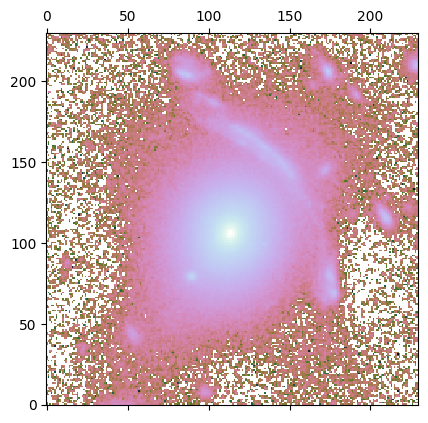

In [6]:
image_data = kwargs_data["image_data"]


plt.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
plt.show()

#### Make mask and plot it

/tmp/ipykernel_21/1057438316.py:63: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
/tmp/ipykernel_21/1057438316.py:74: RuntimeWarning: divide by zero encountered in log10
  ax3.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
/tmp/ipykernel_21/1057438316.py:74: RuntimeWarning: invalid value encountered in log10
  ax3.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")


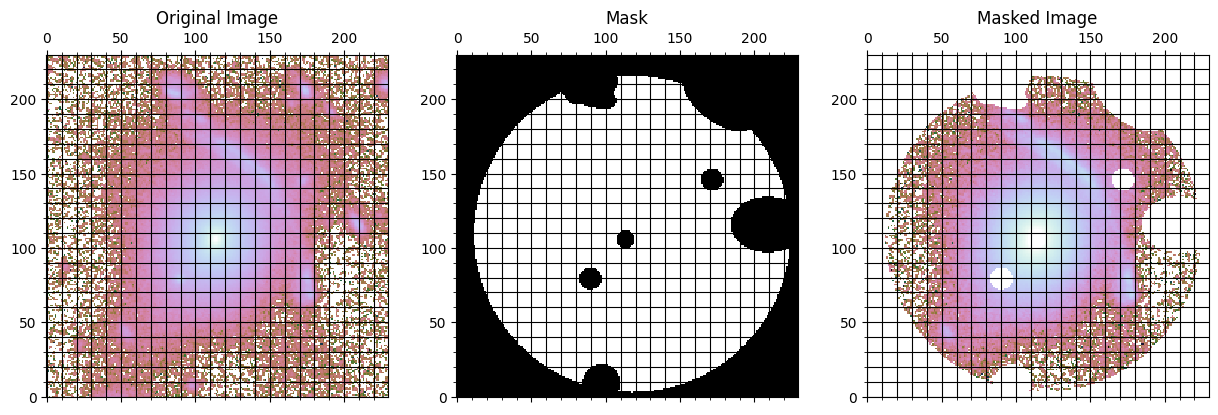

In [7]:
ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r = 8.5  # arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra - 0.2,
    lens_center_dec - 0.5,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)

mask_params = [
    [-7.5, 0, 2, 1.5, -np.pi / 180 * 0],  # x, y, q, phi, theta
    [-5, 7, 1.5, 2.5, -np.pi / 180 * 50],
    [-4.5, 2.4, 0.6, 0.6, 0],
    [2.5, 7.35, 2, 0.8, np.pi / 180 * 25],
    [2, 7.35, 1.5, 0.8, -np.pi / 180 * 20],
    [1.45, -8.5, 1, 1, 0],
    # [5.5, -9, 3.5, 1, 0],
    
    #11 O'clock Arc Left hand thin slice
    # [1.5, 5.75, 0.4, 1, -np.pi / 180 * 68],
    
    #probable lense galaxy fuzzy blob counter image of arc
    # [4.9, -5.7, 0.5, 0.5, -np.pi / 180 * 35],
    [0.15, -0.8, 0.5, 0.5, np.pi / 2],  # center
    # [-1.75, 5, 2.8, 2, np.pi / 4],
    [2.05, -2.9, 0.6, 0.6, np.pi / 2],  # counter object
    # [2.1394, -2.7592, 0.4, 0.4, np.pi / 2], #counter object by model
]

mask = 1 - mask_outer

for mask_param in mask_params:
    mask *= 1 - mask_util.mask_ellipse(
        util.image2array(x_coords),
        util.image2array(y_coords),
        mask_param[0],
        mask_param[1],
        mask_param[2],
        mask_param[3],
        mask_param[4],
    )

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

# mask image data
masked_image_data = np.multiply(image_data, mask)

# plot image and masked image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.matshow(np.log10(image_data), origin="lower", cmap="cubehelix")
ax1.grid(which="both", color="black")
ax1.minorticks_on()
ax1.grid(which="minor", color="black")
ax1.title.set_text("Original Image")
ax2.matshow(mask, origin="lower", cmap="cubehelix")
ax2.grid(which="both", color="black")
ax2.minorticks_on()
ax2.grid(which="minor", color="black")
ax2.title.set_text("Mask")
ax2.title.set_text("Mask")
ax3.matshow(np.log10(masked_image_data), origin="lower", cmap="cubehelix")
ax3.grid(which="both", color="black")
ax3.minorticks_on()
ax3.grid(which="minor", color="black")
ax3.title.set_text("Masked Image")
plt.show()

## Lens Modeling with Lenstronomy

In [8]:
lens_model_list = [
    "EPL",
    "SHEAR",
    #                   "FLEXION"
]
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS", "SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

## Lens Galaxy's Mass Model

### EPL Parameters

In [9]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 3.36,
        "gamma": 2.0,
        "e1": -0.0613,
        "e2": -0.0683,
        "center_x": 0.1581,
        "center_y": -0.77,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.5,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 2.0,
        "gamma": 1,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 4.8,
        "gamma": 3,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

### Shear Parameters

In [10]:
# SHEAR


fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": -0.1605, "gamma2": 0.289})
kwargs_lens_sigma.append({"gamma1": 0.05, "gamma2": 0.05})
kwargs_lower_lens.append({"gamma1": -0.4, "gamma2": -0.4})
kwargs_upper_lens.append({"gamma1": 0.4, "gamma2": 0.4})


"""# FLEXION
fixed_lens.append({"ra_0": 0., "dec_0": 0.})
kwargs_lens_init.append(
    {
        "g1": 0.0,
        "g2": 0.0,
        "g3": 0.0,
        "g4": 0.0,
        "ra_0": 0.0,
        "dec_0": 0.0
    }
)
kwargs_lens_sigma.append({"g1": 0.01, "g2": 0.01, "g3": 0.01, "g4": 0.01,
                          "ra_0": 0., "dec_0": 0.})
kwargs_lower_lens.append({"g1": -0.1, "g2": -0.1, "g3": -0.1, "g4": -0.1,
                         "ra_0": 0., "dec_0": 0.})
kwargs_upper_lens.append({"g1": 0.1, "g2": 0.1, "g3": 0.1, "g4": 0.1,
                         "ra_0": 0., "dec_0": 0.})
"""

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

## Source Galaxy's Light Model

### Sersic Ellipse Parameters

In [11]:
source_x = 4.9  # [4.9, -5.7
source_y = -5.7
source_bound = 1

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.15,
        "n_sersic": 1,
        "e1": -0.136,
        "e2": -0.4303,
        "center_x": source_x,
        "center_y": source_y,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": source_bound / 4,
        "center_y": source_bound / 4,
        "amp": 1,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.004,
        "n_sersic": 0.5,
        "center_x": source_x - source_bound,
        "center_y": source_y - source_bound,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 1,
        "n_sersic": 5.0,
        "center_x": source_x + source_bound,
        "center_y": source_y + source_bound,
        "amp": 10,
    }
)

### Shapelets Parameters

In [12]:
## 1st Shapelet

fixed_source.append({"n_max": 12})
kwargs_source_init.append({"center_x": source_x, "center_y": source_y, "beta": 0.1})
kwargs_source_sigma.append(
    {"center_x": source_bound / 4, "center_y": source_bound / 4, "beta": 0.05}
)  # last beta value 0.001, reason for change - arc recreation not proper
kwargs_lower_source.append(
    {
        "center_x": source_x - source_bound,
        "center_y": source_y - source_bound,
        "beta": 0.001,
    }
)
kwargs_upper_source.append(
    {
        "center_x": source_x + source_bound,
        "center_y": source_y + source_bound,
        "beta": 0.25,
    }
)

joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]

# 2nd Shapelet


fixed_source.append({"n_max": 12})
kwargs_source_init.append({"center_x": 0, "center_y": 0, "beta": 0.05})
kwargs_source_sigma.append({"center_x": 0.2, "center_y": 0.2, "beta": 0.05})
kwargs_lower_source.append({"center_x": -10, "center_y": -10, "beta": 0.001})
kwargs_upper_source.append({"center_x": 10, "center_y": 10, "beta": 0.25})

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

## Lens Galaxy's Light Model

### 1st Sersic Ellipse Parameters

In [13]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 5.415,
        "n_sersic": 4.0,
        "e1": -0.0613,
        "e2": -0.0683,
        "center_x": 0.1581,
        "center_y": -0.778,
        "amp": 1,
    }
)

kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.5,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)
joint_lens_with_light_temp = [[0, 0, ["center_x", "center_y", "e1", "e2"]]]

### 2nd Sersic Ellipse Parameters

In [14]:
fixed_lens_light.append({"n_sersic": 1.0})


kwargs_lens_light_init.append(
    {
        "R_sersic": 6.53,
        "n_sersic": 1.0,
        "e1": -0.061,
        "e2": -0.0683,
        "center_x": 0.1560,
        "center_y": -0.775,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.5,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.2,
        "center_y": 0.2,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 15,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

In [15]:
# Combining all the above specification in the `kwargs_params` dictionary

kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

"""# For PSO
kwargs_constraints_temp = {
    "joint_lens_with_light": joint_lens_with_light_temp,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_shapelets_with_sersic,
}
"""
# For MCMC
kwargs_constraints = {
    "joint_lens_with_light": joint_lens_with_light_temp,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    "joint_source_with_source": joint_shapelets_with_sersic,
    "image_plane_source_list": [True, True, True],
}

In [16]:
kwargs_likelihood = {
    "check_bounds": True,
    "image_likelihood_mask_list": [mask],
    #                     "check_positive_flux": True
}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

In [17]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band
    # has independent solutions of the
    # surface brightness, 'joint-linear':
    # there is one joint solution of the
    # linear coefficients demanded across the bands.
}

## The Model Fitting

In [18]:
fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

fitting_kwargs_list = [
    ["update_settings", {"lens_add_fixed": [[0, ["gamma"]]]}],
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 150}],
    ["update_settings", {"lens_remove_fixed": [[0, ["gamma"]]]}],
]


chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Max iteration reached! Stopping.
-1.0844396111964356 reduced X^2 of best position
-17416.100155814755 log likelihood
32120 effective number of data points
[{'theta_E': 3.418147252322524, 'gamma': 2.0, 'e1': -0.06694300182577494, 'e2': -0.06985393945806102, 'center_x': 0.15240229537102512, 'center_y': -0.7663486050060285}, {'gamma1': -0.1657778952755815, 'gamma2': 0.2942421583047559, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.9959654131533099, 'n_sersic': 1.0, 'e1': 0.3859349802515043, 'e2': -0.4570516791211627, 'center_x': 4.558190111401126, 'center_y': -3.7447872404663585}, {'amp': 1, 'n_max': 12, 'beta': 0.24959583235743082, 'center_x': 4.558190111401126, 'center_y': -3.7447872404663585}, {'amp': 1, 'n_max': 12, 'beta': 0.23306236203773595, 'center_x': -1.4807762215943638, 'center_y': 0.7920048701167198}] source result
[{'amp': 1, 'R_sersic': 4.0725808647641575, 'n_sersic': 4.0, 'e1': -0.06694

In [19]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "DESIJ1539+1650_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualizing the Fitted Model

-1.0776289424331194 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0776289424331162


/opt/conda/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/opt/conda/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/opt/conda/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/opt/conda/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
/opt/conda/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: invalid value encountered in log10
  np.log10(self._model),


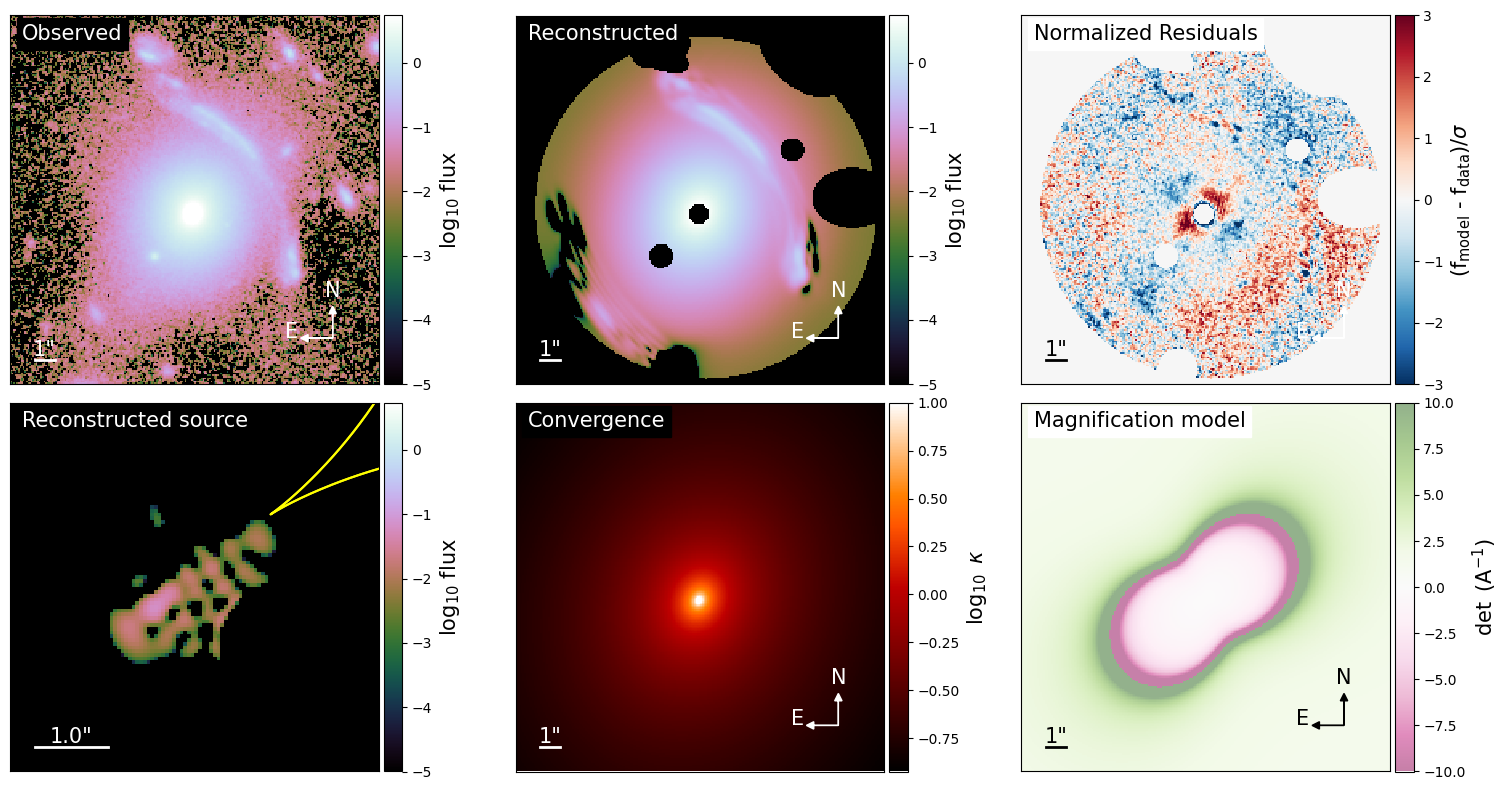

/opt/conda/lib/python3.10/site-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


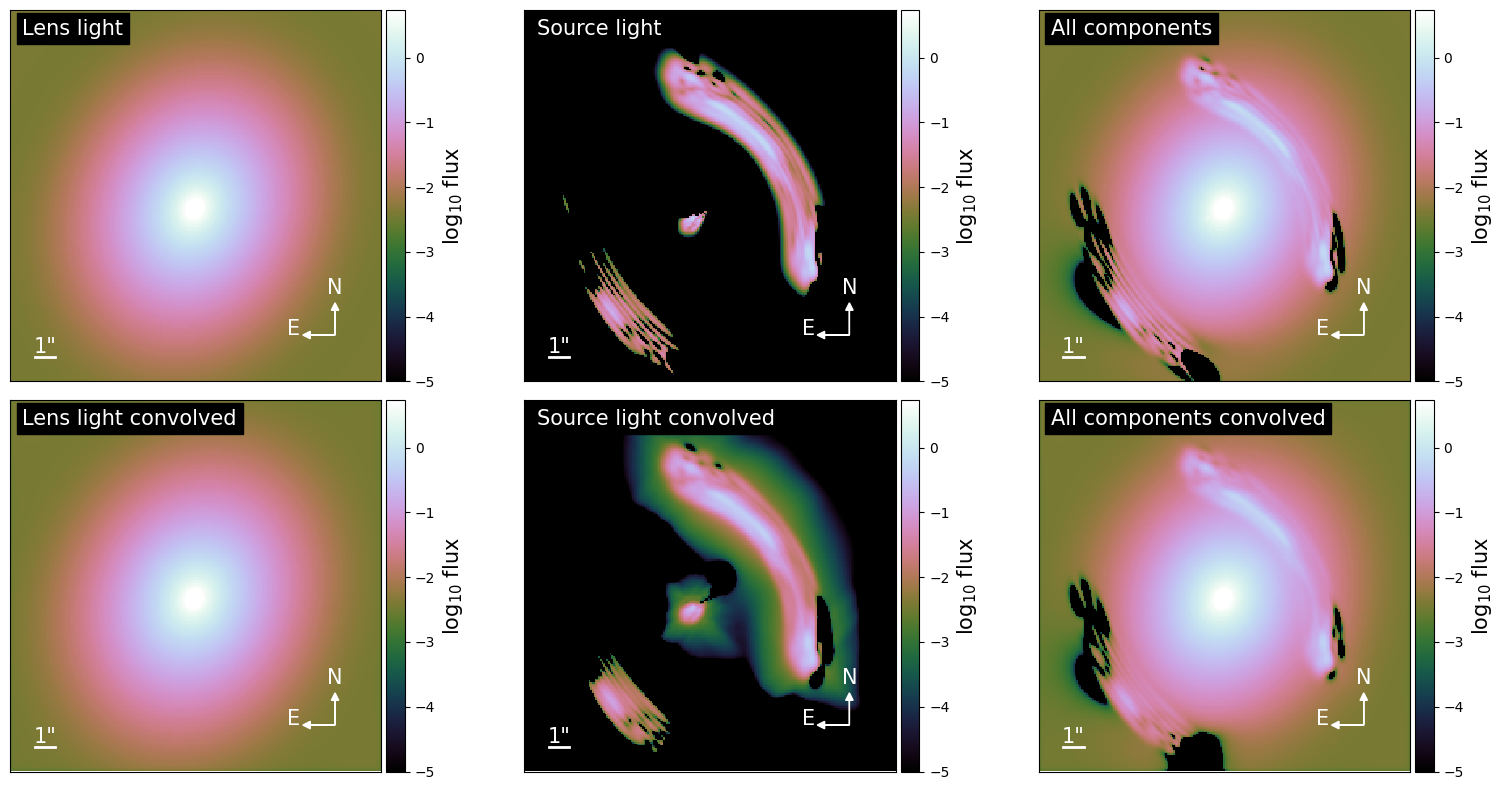

{'kwargs_lens': [{'theta_E': 3.418147252322524, 'gamma': 2.0, 'e1': -0.06694300182577494, 'e2': -0.06985393945806102, 'center_x': 0.15240229537102512, 'center_y': -0.7663486050060285}, {'gamma1': -0.1657778952755815, 'gamma2': 0.2942421583047559, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': -1.6507048732418146, 'R_sersic': 0.9959654131533099, 'n_sersic': 1.0, 'e1': 0.3859349802515043, 'e2': -0.4570516791211627, 'center_x': 4.558190111401126, 'center_y': -3.7447872404663585}, {'amp': array([  23.87966769,    8.87314738,   -0.30254677,    3.90611266,
        -26.85874945,   -4.71632352,   25.56243837,   18.49214261,
         18.67631151,    3.17602392,  -26.87373721,  -65.77096669,
        -38.30551221,  -23.13927746,   -6.31381187,   42.8800696 ,
         69.84257271,   83.59153338,   53.5623146 ,   22.8027703 ,
          1.47888986,  -44.39670142, -100.5574694 , -102.97425889,
        -89.17949056,  -47.43131424,  -17.1499007 ,   -5.32572888,
         39.22094155,   94.60088303, 

In [20]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True),
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.05, numPix=100, with_caustics=True, scale_size=1
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()
print(kwargs_result)

MCMC

In [21]:
mcmc_backend = "mcmc_backend.h5"

fitting_kwargs_list_mcmc = [
    [
        "MCMC",
        {
            "n_burn": 0,
            "n_run": 400,
            "n_walkers": 150,
            "sigma_scale": 0.1,
            "threadCount": 3,
            "backend_filename": mcmc_backend,
            "start_from_backend": True,
        },
    ]
]


chain_list_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq.best_fit()

ValueError: Cannot have `initial_state=None` if run_mcmc has never been called.

Trace Plot

In [ ]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

In [ ]:
samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 150
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

Corner Plot

In [ ]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 0
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

MCMC: Visualizing the Fitted Model


In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.1, numPix=100, with_caustics=True, scale_size=0.5
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

Mass and Light Ellipticity of the Lens Galaxy


In [ ]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}".format(
        mass_q,
        light_q,
    )
)

Save the Best Fit Parameters (MCMC)


In [ ]:
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result_mcmc, multi_band_list_out, kwargs_fixed_out]

output_path = "DESIJ1539+1650_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=9)